# Introduction

A list of tweets have been classified as either neutral, negative, or positive.  The model predicts selected text in the tweets that determines the classified sentiment.

https://www.kaggle.com/c/tweet-sentiment-extraction/overview/evaluation

X = text, sentiment

y = selected_text


# Libraries


### Public libraries

In [ ]:
import pandas as pd
import numpy as np
import random

# seaborn
import seaborn as sns

# nltk library
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import FreqDist
from nltk import classify
from nltk import NaiveBayesClassifier
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# keras
from keras import layers

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Custom functions

In [ ]:
def clean_text(tokenized_sentence):
  """
  Input = list of strings that is tokenized sentence 

  Return = list of strings that is a lower case tokenized sentence
  """
  lower_case_words = []
  for words in tokenized_sentence:
    lower_case_words.append(words.lower())

  return lower_case_words

### Score function

In [ ]:
# Compares the words between actual and prediction
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

# Same function except for already tokenized text
def jaccard_token(str1, str2): 
    a = set(str1) 
    b = set(str2)
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

# EDA


### Data Structure

In [ ]:
# Load the dataset
train = pd.read_csv('https://raw.githubusercontent.com/sli0111/tweet_sentiment_extraction/main/train.csv')
train.head(10)
print(train.shape)

(27481, 4)


Notice that for text that are considered neutral, the selected text is just the text.

In [ ]:
# Check for missing values
np.sum(train.isna())

train[train['text'].isna()]

,textID,text,selected_text,sentiment
314,fdb77c3752,NaN,NaN,neutral


In [ ]:
# Replace row 314 with 0
train = train.fillna('0')
np.sum(train.isna())

textID           0
text             0
selected_text    0
sentiment        0
dtype: int64

In [ ]:
# All text objects
train.dtypes

textID           object
text             object
selected_text    object
sentiment        object
dtype: object

In [ ]:
# Total unique IDs match total rows
train.shape[0] == np.sum(np.unique(train['textID'], return_counts=True)[1])

True

Overall the data is clean.  Each row is a unique ID.  Removed one missing row of data.

### Data

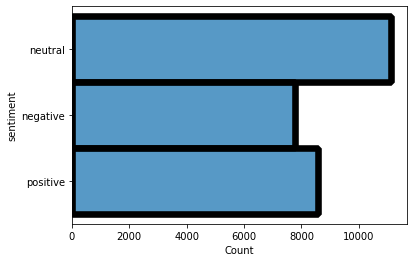

In [ ]:
# Distribution of sentiment - a lot of neutrals
sns.histplot(y='sentiment', data=train)

The figure above shows the that majority of the text are considered netural.

In [ ]:
# Convert the selected_text to word tokens
word_tokens = [word_tokenize(str(i)) for i in train['selected_text']]
clean_tokens = [clean_text(i) for i in word_tokens]
train['selected_text_tokens'] = clean_tokens

# Convert the text to word tokens
word_tokens = [word_tokenize(str(i)) for i in train['text']]
clean_tokens = [clean_text(i) for i in word_tokens]
train['text_tokens'] = clean_tokens

train.head(5)


,textID,text,selected_text,sentiment,selected_text_tokens,text_tokens
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,"[i`d, have, responded, ,, if, i, were, going]","[i`d, have, responded, ,, if, i, were, going]"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,"[sooo, sad]","[sooo, sad, i, will, miss, you, here, in, san,..."
2,088c60f138,my boss is bullying me...,bullying me,negative,"[bullying, me]","[my, boss, is, bullying, me, ...]"
3,9642c003ef,what interview! leave me alone,leave me alone,negative,"[leave, me, alone]","[what, interview, !, leave, me, alone]"
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,"[sons, of, ****, ,]","[sons, of, ****, ,, why, couldn`t, they, put, ..."


In [ ]:
def get_all_words(tokens_list):
  for tokens in tokens_list:
    for token in tokens:
      yield token

pos_train = train[train['sentiment'] == 'positive']
neg_train = train[train['sentiment'] == 'negative']

all_pos_words = get_all_words(pos_train['text_tokens'])
all_neg_words = get_all_words(neg_train['text_tokens'])

print(FreqDist(all_pos_words).most_common(10))
print(FreqDist(all_neg_words).most_common(10))

[('!', 6629), ('.', 4440), ('i', 3773), ('the', 2996), ('to', 2975), (',', 2812), ('a', 2385), ('you', 2075), ('and', 1678), ('my', 1485)]
[('i', 4586), ('.', 4580), ('!', 3918), ('to', 2893), ('the', 2454), (',', 2319), ('my', 2035), ('a', 1807), ('...', 1707), ('and', 1579)]


# Baseline Model

A Naive Bayes Classifier will be used as a first model below

### Create dictionaries for each tweet

In [ ]:
# Returns a generative object of dictionaries
# Tags True for the sentiment the text belongs to
def get_tweets_for_model(cleaned_tokens_list):
  for tweet_tokens in cleaned_tokens_list:
    yield dict([token, True] for token in tweet_tokens)
                                                 

In [ ]:
# Add the dictionaries to the train dataframe to ease of visualization
train['tokens_for_model'] = [(tweet_dict, train['sentiment'][i]) 
                              for i, tweet_dict in enumerate(get_tweets_for_model(train['text_tokens']))]
train['tokens_for_model']
                            

0        ({'i`d': True, 'have': True, 'responded': True...
1        ({'sooo': True, 'sad': True, 'i': True, 'will'...
2        ({'my': True, 'boss': True, 'is': True, 'bully...
3        ({'what': True, 'interview': True, '!': True, ...
4        ({'sons': True, 'of': True, '****': True, ',':...
                               ...                        
27476    ({'wish': True, 'we': True, 'could': True, 'co...
27477    ({'i`ve': True, 'wondered': True, 'about': Tru...
27478    ({'yay': True, 'good': True, 'for': True, 'bot...
27479    ({'but': True, 'it': True, 'was': True, 'worth...
27480    ({'all': True, 'this': True, 'flirting': True,...
Name: tokens_for_model, Length: 27481, dtype: object

### Split Train Dev

In [ ]:
# Ignore the neutral values
train_data = train[train['sentiment'] != 'neutral'][:13000]
dev_data = train[train['sentiment'] != 'neutral'][13000:]

# Split to train
X_train = list(train_data['tokens_for_model'])
sentiment_train = list(train_data['sentiment'])
y_train = list(train_data['selected_text'])
y_train_tokens = list(train_data['selected_text_tokens'])

# Split to dev
X_dev = list(dev_data['tokens_for_model'])
sentiment_dev = list(dev_data['sentiment'])
y_dev = list(dev_data['selected_text'])
y_dev_tokens = list(dev_data['selected_text_tokens'])

### Model

In [ ]:
# Naive Bayes Classifier
classifier = NaiveBayesClassifier.train(X_train)
print("Accuracy is:", classify.accuracy(classifier, X_dev))

print(classifier.show_most_informative_features())

Accuracy is: 0.8650014867677669
Most Informative Features
                mother`s = True           positi : negati =     91.2 : 1.0
                   sucks = True           negati : positi =     61.6 : 1.0
                   thank = True           positi : negati =     50.4 : 1.0
                     sad = True           negati : positi =     50.3 : 1.0
                    hate = True           negati : positi =     48.9 : 1.0
                   bored = True           negati : positi =     43.3 : 1.0
                 welcome = True           positi : negati =     43.1 : 1.0
                    moms = True           positi : negati =     38.4 : 1.0
                 awesome = True           positi : negati =     36.1 : 1.0
                   hurts = True           negati : positi =     33.8 : 1.0
None


In [ ]:
# Returns the tokens and/or index with highest probability in each sentiment
def high_word_sentiment(sent_dict, label, threshold):
  top_values = [] 
  index = []  
  i = 0
  for key, value in sent_dict.items():
    word_dict = {key: value}
    dist = classifier.prob_classify(word_dict)
    if dist.prob(label) > threshold:
      top_values.append(key)
      index.append(i)
    i += 1
  return top_values, index

In [ ]:
# Returns the prediction of the data based on threshold probability t
def baseline_predictions(data, t):
  predictions = []
  for i in range(len(data)):
    guess_word, guess_index = high_word_sentiment(data[i][0], data[i][1], threshold=t)
    predictions.append(guess_word)
  return predictions

In [ ]:
# Sample predictions
baseline_predictions_train = baseline_predictions(X_train, t=0.7)
baseline_predictions_dev = baseline_predictions(X_dev, t=0.7)

baseline_predictions_train[0:10]

[['sad', 'miss', 'diego'],
 ['bullying'],
 [],
 ['****', 'why', 'couldn`t'],
 ['feedings', 'fun', 'smiles', 'coos'],
 ['journey', 'wow', 'became', 'cooler', 'hehe'],
 ['song', 'love', 'taylor', 'swift'],
 ['sharpie', 'dangerously', 'ink'],
 ['lost'],
 ['sunburned']]

In [ ]:
# Relative to actual
y_train_tokens[0:10]

[['sooo', 'sad'],
 ['bullying', 'me'],
 ['leave', 'me', 'alone'],
 ['sons', 'of', '****', ','],
 ['fun'],
 ['wow', '...', 'u', 'just', 'became', 'cooler', '.'],
 ['like'],
 ['dangerously'],
 ['lost'],
 ['uh', 'oh', ',', 'i', 'am', 'sunburned']]

### Model Score

In [ ]:
# Jaccuard token score for several thresholds
t_values = np.linspace(0.1, 0.9, 5)
for t in t_values:
  baseline_predictions_train = baseline_predictions(X_train, t=t)

  scores = []
  num_examples = len(baseline_predictions_train)
  for i in range(num_examples):
    scores.append(jaccard_token(baseline_predictions_train[i], y_train_tokens[i]))

  avg_score = np.sum(scores)/num_examples
  print(round(avg_score, 3))

0.332
0.329
0.297
0.285
0.23


In [ ]:
# Similarty for dev
t_values = np.linspace(0.1, 0.9, 5)
for t in t_values:
  baseline_predictions_train = baseline_predictions(X_dev, t=t)

  scores = []
  num_examples = len(baseline_predictions_dev)
  for i in range(num_examples):
    scores.append(jaccard_token(baseline_predictions_dev[i], y_dev_tokens[i]))

  avg_score = np.sum(scores)/num_examples
  print(round(avg_score, 3))

0.3
0.3
0.3
0.3
0.3


# Bert

# References

https://www.digitalocean.com/community/tutorials/how-to-perform-sentiment-analysis-in-python-3-using-the-natural-language-toolkit-nltk